<a href="https://colab.research.google.com/github/yashnegi11/RAG-multiagent-Assistant/blob/main/RAGmultiagentAssistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RAG-Powered Multi-Agent Q&A Assistant



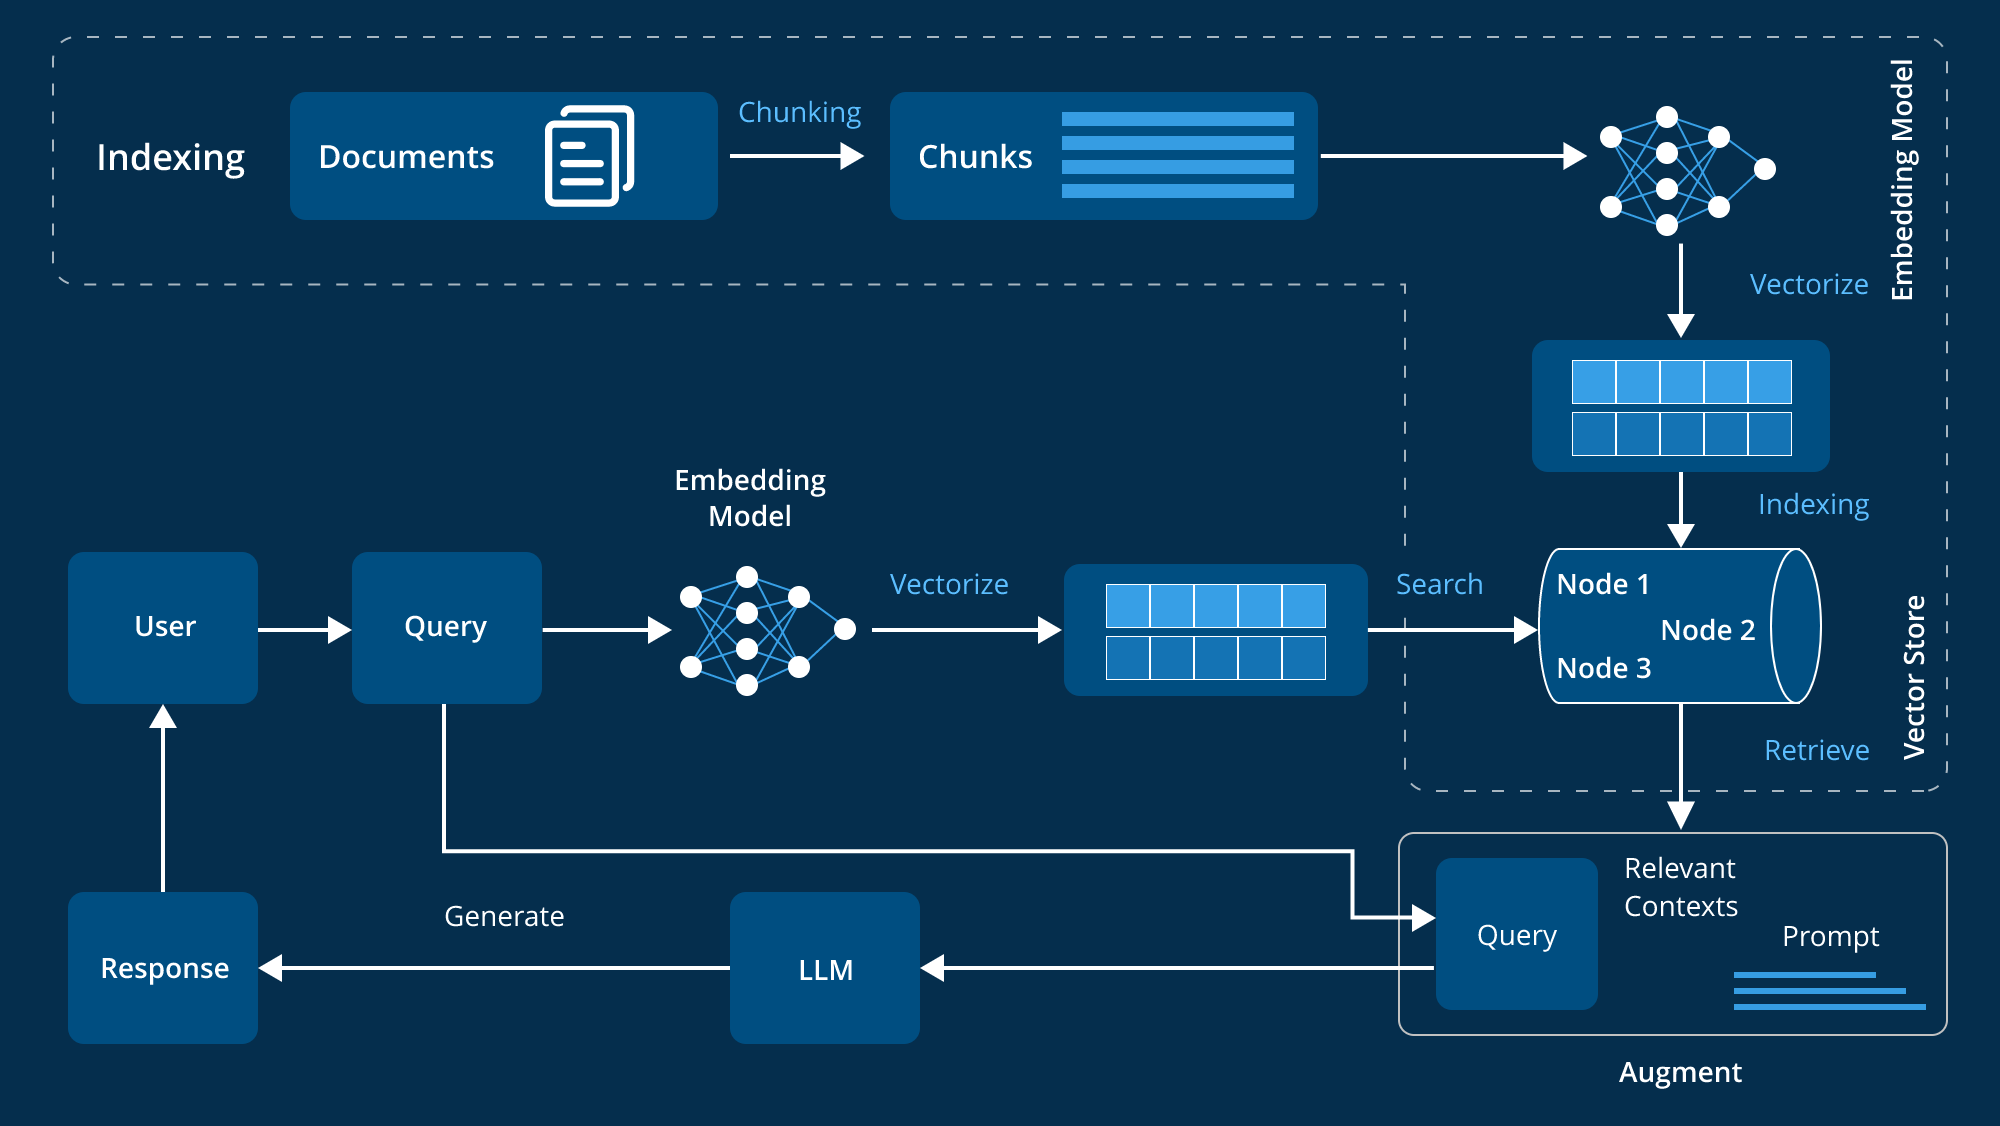

In [1]:
#Install dependencies
!pip install -q faiss-cpu langchain transformers sentence-transformers langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [2]:
#Prepare txt documents
docs = {
    'faq.txt': '''Q: What is your return policy?\nA: Return items within 30 days.\n\nQ: Support?\nA: 24/7 support available.''',
    'product.txt': '''Product A: Smartwatch, 7-day battery.\nProduct B: Wireless headphones, 20hr battery.''',
    'about.txt': '''We are TechNova, creators of smart devices. Founded in 2018 in San Francisco.'''
}

for name, content in docs.items():
    with open(name, 'w') as f:
        f.write(content)

In [ ]:
#Ingest and chunk documents
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=20)
docs_list = []

for name, content in docs.items():
    chunks = splitter.split_text(content)
    docs_list.extend([Document(page_content=chunk, metadata={"source": name}) for chunk in chunks])

embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(docs_list, embedding_model)

In [4]:
# Retrieval function
def retrieve(query, k=3):
    return vectorstore.similarity_search(query, k=k)

In [ ]:
#LLM integration
from transformers import pipeline
qa_model = pipeline("text2text-generation", model="google/flan-t5-base")

def generate_answer(query, context):
    prompt = f"Answer based on context:\n{context}\n\nQuestion: {query}"
    return qa_model(prompt, max_new_tokens=100)[0]['generated_text']

In [6]:
#Agent logic
import re
import requests

def route_query(query):
    if re.search(r"(calculate|\d+\s*[\+\-\*/]\s*\d+)", query):
        return "calculator"
    elif re.search(r"(define|meaning of)", query):
        return "dictionary"
    return "rag"

def get_definition(term):
    try:
        word = term.lower().strip()
        url = f"https://api.dictionaryapi.dev/api/v2/entries/en/{word}"
        response = requests.get(url)
        if response.status_code != 200:
            return f"No definition found for '{word}'."
        data = response.json()
        meaning = data[0]["meanings"][0]["definitions"][0]["definition"]
        return f"{word.capitalize()}: {meaning}"
    except Exception as e:
        return f"Error fetching definition: {str(e)}"

def process_query(query):
    route = route_query(query)
    log = f"Routing: {route}"

    if route == "calculator":
        try:
            return log, "", str(eval(query))
        except:
            return log, "", "Invalid calculation"
    elif route == "dictionary":
        word = query.lower().replace("define", "").replace("meaning of", "").strip()
        definition = get_definition(word)
        return log, "", definition
    else:
        docs = retrieve(query)
        ctx = "\n".join([d.page_content for d in docs])
        ans = generate_answer(query, ctx)
        return log, ctx, ans

In [7]:
#Demo CLI
while True:
    q = input("Ask (or 'exit'): ")
    if q.lower() == 'exit': break
    log, ctx, ans = process_query(q)
    print("\n" + log)
    if ctx:
        print("\nContext:\n" + ctx)
    print("\nAnswer:\n" + ans)

Ask (or 'exit'): what is return policy?

Routing: rag

Context:
Q: What is your return policy?
A: Return items within 30 days.

Q: Support?
A: 24/7 support available.
Product A: Smartwatch, 7-day battery.
Product B: Wireless headphones, 20hr battery.
We are TechNova, creators of smart devices. Founded in 2018 in San Francisco.

Answer:
Return items within 30 days
Ask (or 'exit'): define RAG

Routing: dictionary

Answer:
Rag: (in the plural) Tattered clothes.
Ask (or 'exit'): 15*2

Routing: calculator

Answer:
30
Ask (or 'exit'): exit
